In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from jax import config
config.update('jax_enable_x64', True)
import matplotlib.pyplot as plt
import corner
import pandas as pd

In [2]:
# RBF kernel
def cov_rbf(x, tau, alpha, sigma):
    dx = x[:,None] - x[None, :]
    return alpha**2 * jnp.exp(-0.5 * (dx / tau)**2) + jnp.diag(sigma**2)

Here the data is given by $y = f(x) + \epsilon$, where
$$
f(x) =  \begin{cases}
c\,(1 - \delta), &|x| < D\\
c, &\mathrm{otherwise}
\end{cases}
$$ and $\epsilon$ is drawn from a Gaussian process. We infer $c$, $\delta$, and GP hyperparameters assuming $D$ is known, and see what happens.

## signal (box + correlated noise)

In [3]:
box_half_width = 4.5
box_depth = 0.3

In [4]:
x = np.linspace(-10, 10, 100)
y_true = np.where(np.abs(x)<box_half_width, 1.-box_depth, 1.)

In [5]:
tau = 1.
alpha = 0.05
sigma = 0.05

In [6]:
mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov_rbf(x, tau, alpha, jnp.ones_like(x)*sigma))

In [7]:
y = y_true + mv.sample(random.PRNGKey(0))

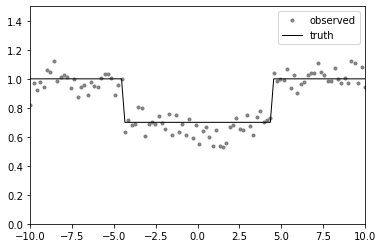

In [8]:
plt.xlim(-10, 10)
plt.ylim(0, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.legend(loc='best');

## successful GP fit

In [9]:
def model_gp(x, yobs):
    norm = numpyro.sample("norm", dist.Uniform(0., 1.5))
    depth = numpyro.sample("depth", dist.Uniform(0., 1.))
    sigma = numpyro.sample("sigma", dist.Exponential(10.))
    ymodel = numpyro.deterministic("ymodel", jnp.where(jnp.abs(x)<box_half_width, norm*(1.-depth), norm))
    
    lna = numpyro.sample("lna", dist.Uniform(-5, -1))
    lntau = numpyro.sample("lntau", dist.Uniform(-2, 2))
    cov = cov_rbf(x, jnp.exp(lntau), jnp.exp(lna), sigma*jnp.ones_like(x))
    
    numpyro.sample("obs", dist.MultivariateNormal(loc=ymodel, covariance_matrix=cov), obs=yobs)

In [10]:
kernel = numpyro.infer.NUTS(model_gp)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [11]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

sample: 100%|█████████| 1000/1000 [00:05<00:00, 172.26it/s, 7 steps of size 4.81e-01. acc. prob=0.92]


In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     depth      0.31      0.02      0.31      0.28      0.35    221.36      1.00
       lna     -3.19      0.37     -3.19     -3.72     -2.67    219.75      1.01
     lntau     -0.20      0.47     -0.24     -0.98      0.58    176.27      1.00
      norm      0.98      0.02      0.99      0.95      1.02    245.51      1.00
     sigma      0.06      0.00      0.06      0.05      0.06    465.04      1.00

Number of divergences: 0


In [13]:
samples = mcmc.get_samples()

In [14]:
def cov_rbf_x(x, x2, tau, alpha):
    dx = x[:,None] - x2[None, :]
    return alpha**2 * jnp.exp(-0.5 * (dx / tau)**2) 

In [15]:
def compute_prediction(x_pred, x, samples, idx):
    a, tau, ymodel = jnp.exp(samples['lna'][idx]), jnp.exp(samples['lntau'][idx]), samples['ymodel'][idx]
    Ksigma = cov_rbf(x, tau, a, sigma*jnp.ones_like(x))
    Kpred = cov_rbf(x_pred, tau, a, jnp.zeros_like(x_pred))
    Kx = cov_rbf_x(x, x_pred, tau, a)
    y_pred = jnp.dot(Kx.T, jnp.linalg.solve(Ksigma, y-ymodel))
    cov_pred = Ksigma - Kx.T@jnp.linalg.solve(Ksigma, Kx)
    sigma_pred = jnp.sqrt(jnp.diag(cov_pred))
    return y_pred, sigma_pred

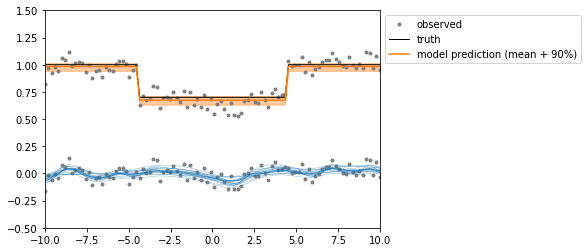

In [16]:
#preds = predictions(samples_gp, model_gp, x, y)
plt.xlim(-10, 10)
plt.ylim(-0.5, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.plot(x, np.mean(samples['ymodel'], axis=0), color='C1', alpha=1, label='model prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(samples['ymodel'], [5,95], axis=0), color='C1', alpha=0.4)
plt.plot(x, y-np.mean(samples['ymodel'], axis=0), '.', color='gray')
#plt.plot(x, np.mean(preds['gppred'], axis=0), color='C0', alpha=1, label='GP prediction (mean + 90%)')
#plt.fill_between(x, *np.percentile(preds['gppred'], [5,95], axis=0), color='C0', alpha=0.4)
np.random.seed(123)
for idx in np.random.randint(0, 500, 20):
    mu_, sigma_ = compute_prediction(x, x, samples, idx)
    plt.plot(x, mu_, color='C0', lw=0.5, alpha=0.5)
plt.legend(loc='best', bbox_to_anchor=(1,1));

## GP fit, forcing large alpha and tau

In [17]:
def model_gp_offset(x, yobs):
    norm = numpyro.sample("norm", dist.Uniform(0., 1.5))
    depth = numpyro.sample("depth", dist.Uniform(0., 1.))
    sigma = numpyro.sample("sigma", dist.Exponential(10.))
    ymodel = numpyro.deterministic("ymodel", jnp.where(jnp.abs(x)<box_half_width, norm*(1.-depth), norm))
    
    lna = numpyro.sample("lna", dist.Uniform(-1, 1))
    lntau = numpyro.sample("lntau", dist.Uniform(0, 4))
    cov = cov_rbf(x, jnp.exp(lntau), jnp.exp(lna), sigma*jnp.ones_like(x))
    
    numpyro.sample("obs", dist.MultivariateNormal(loc=ymodel, covariance_matrix=cov), obs=yobs)

In [18]:
kernel = numpyro.infer.NUTS(model_gp_offset)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [19]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

sample: 100%|█████████| 1000/1000 [00:13<00:00, 76.82it/s, 63 steps of size 1.06e-01. acc. prob=0.90]


In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     depth      0.40      0.18      0.36      0.17      0.68    128.87      1.00
       lna     -0.59      0.35     -0.69     -0.99     -0.12    324.25      1.00
     lntau      3.00      0.79      3.23      1.89      4.00    138.63      1.00
      norm      0.85      0.32      0.81      0.38      1.37    183.18      1.00
     sigma      0.06      0.00      0.06      0.06      0.07    228.56      1.00

Number of divergences: 0


In [21]:
samples = mcmc.get_samples()

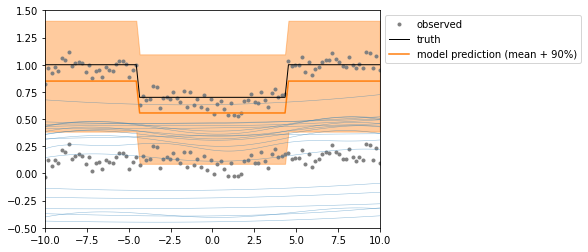

In [22]:
plt.xlim(-10, 10)
plt.ylim(-0.5, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.plot(x, np.mean(samples['ymodel'], axis=0), color='C1', alpha=1, label='model prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(samples['ymodel'], [5,95], axis=0), color='C1', alpha=0.4)
plt.plot(x, y-np.mean(samples['ymodel'], axis=0), '.', color='gray')
np.random.seed(123)
for idx in np.random.randint(0, 500, 20):
    mu_, sigma_ = compute_prediction(x, x, samples, idx)
    plt.plot(x, mu_, color='C0', lw=0.5, alpha=0.5)
plt.legend(loc='best', bbox_to_anchor=(1,1));

###  normalization and GP mean are completely degenerate...

In [23]:
# mean of GP prediction
mus = []
for idx in range(500):
    mu_, _ = compute_prediction(x, x, samples, idx)
    mus.append(np.mean(mu_))
samples['gpmean'] = np.array(mus)

In [24]:
keys = ['depth', 'lna', 'lntau', 'norm', 'sigma', 'gpmean']
smp_df = pd.DataFrame(dict(zip(keys, [samples[key] for key in keys])))

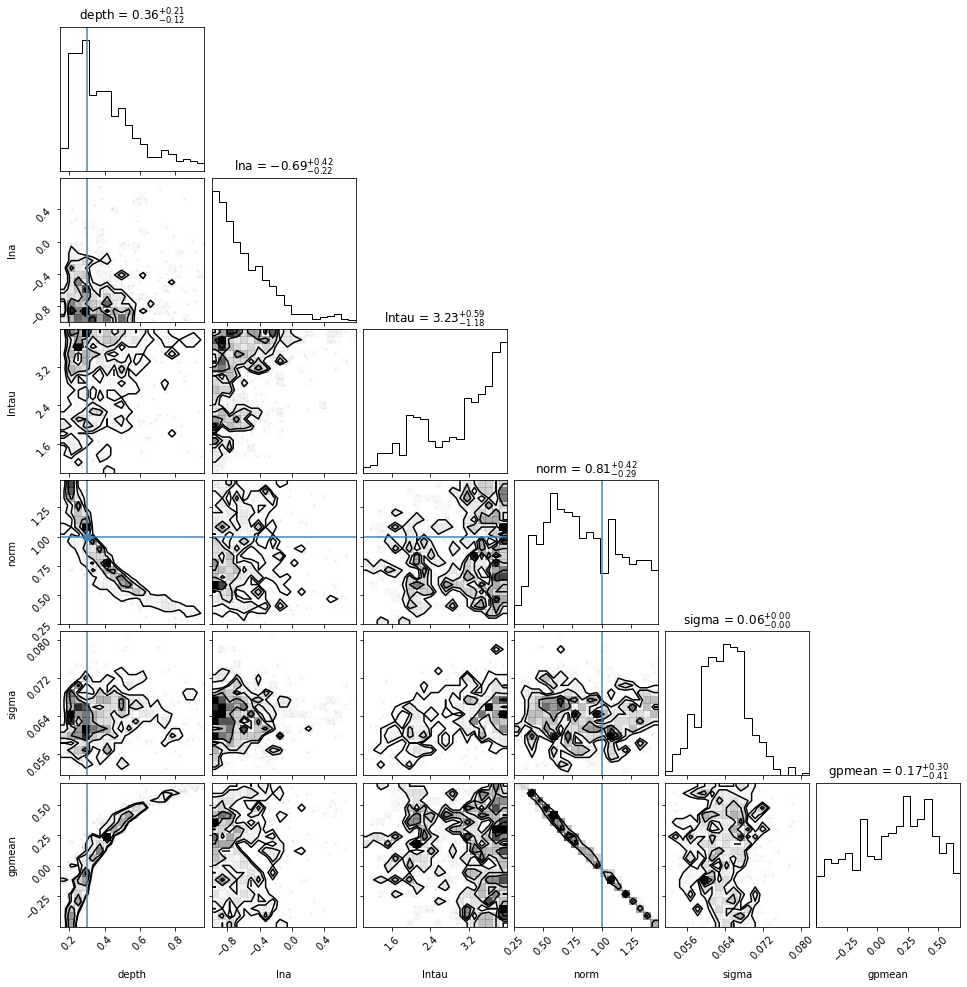

In [25]:
fig = corner.corner(smp_df, labels=keys, show_titles=True, title_fmt='.2f', 
                    truths=[0.3, np.log(alpha), np.log(tau), 1., sigma, None]);